In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings  
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix

# 1. 데이터 불러오기

In [2]:
# 유저 데이터
user = pd.read_csv('data/member_mate_sample.csv')

# 성혼 데이터
married = pd.read_csv('data/married_success_sample_processing_f.csv', index_col=0)

# 비성혼 데이터
not_married = pd.read_csv('data/not_married_test_sample.csv', index_col=0)

# 행렬분해 top20 데이터
top20 = pd.read_csv('data/top20.csv')

# 2. 데이터 전처리

In [3]:
# target 성혼 :1, 비성혼 :0
married['target'] = 1
not_married['target'] = 0

In [4]:
data = pd.concat([married, not_married])
data = data.reset_index(drop=True)

In [5]:
data = data[['mem_no','mate_slct','mem_loc','mem_birth_year','mate_ann_salary','possess_property','mate_height','mate_career',
             'ptr_mem_no','ptr_mate_slct','ptr_mem_loc','ptr_mem_birth_year','ptr_mate_ann_salary','ptr_possess_property','ptr_mate_height','ptr_mate_career','target']]

In [6]:
# 테스트 데이터 구축
user31 = user[user['mem_no'] == 31]
user31 = user31[['mem_no','mate_slct','mem_loc','mem_birth_year','mate_ann_salary','possess_property','mate_height','mate_career']]

for i in range(19):
    user31 = user31.append(user31.iloc[0,:])
    
user_top20 = user[user['mem_no'] == top20['ptr_mem_no'][0]]

for i in range(1, len(top20)):
    user_top20 = user_top20.append(user[user['mem_no'] == top20['ptr_mem_no'][i]])
    
    user_top20 = user_top20[['mem_no','mate_slct','mem_loc','mem_birth_year','mate_ann_salary','possess_property','mate_height','mate_career']]
user_top20.columns = ['ptr_mem_no','ptr_mate_slct','ptr_mem_loc','ptr_mem_birth_year','ptr_mate_ann_salary','ptr_possess_property','ptr_mate_height','ptr_mate_career']

user31.reset_index(inplace=True, drop=True)
user_top20.reset_index(inplace=True, drop=True)

concat = pd.concat([user31, user_top20], axis=1)

In [7]:
data = pd.concat([data, concat], axis=0)

In [8]:
# 초혼, 재혼 추가 # 원핫 인코딩

data = pd.get_dummies(data, columns = ['mate_slct'])
data = pd.get_dummies(data, columns = ['ptr_mate_slct'])

In [9]:
def loc(x) :
  if x == 'h' : return 'c'   # 부산 > 경남
  elif x == 'f' : return 'd' # 대구 > 경북
  elif x == 'e' : return 'l'  # 광주 > 전남
  elif x == 'g' : return 'o'  # 대전 > 충남
  elif x == 'i' : return 'b' # 서울 > 경기
  elif x == 'z' : return 'p' # 세종 > 충북
  elif x == 'j' : return 'c' # 울산 > 경남
  elif x == 'k' : return 'b' # 인천 > 경기 
  elif x == 'y' : return 'q' # 북한 > 해외
  else : return x

# 'a':'강원', 'b':'경기', 'c':'경남', 'd':'경북',
# 'l':'전남', 'n':'전북', 'm':'제주', 'o':'충남', 'p':'충북', 
# 'q':'해외',

In [10]:
# 지역적용

data['mem_loc_p'] = data['mem_loc'].apply(loc)
data['ptr_mem_loc_p'] = data['ptr_mem_loc'].apply(loc)

data = pd.get_dummies(data, columns = ['mem_loc_p'])
data = pd.get_dummies(data, columns = ['ptr_mem_loc_p'])

# 3. 데이터 탐색(EDA)

<AxesSubplot:xlabel='mem_birth_year - ptr_mem_birth_year', ylabel='Count'>

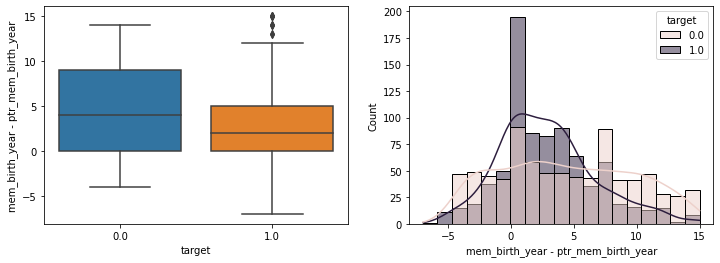

In [11]:
# 나이 차이
data['mem_birth_year - ptr_mem_birth_year'] =  - (data['mem_birth_year'] - data['ptr_mem_birth_year'])

fig, axs = plt.subplots(figsize = (12,4), nrows=1, ncols=2)

sns.boxplot(data=data, y= 'mem_birth_year - ptr_mem_birth_year', x = 'target', ax = axs[0])
sns.histplot(data=data, x= 'mem_birth_year - ptr_mem_birth_year', hue = 'target', kde = True, ax = axs[1])

In [12]:
def salary(x) :

    if x == 12 :
      return 1

    elif x >= 13 :
      return 30

    else :
      return x

<AxesSubplot:xlabel='mate_ann_salary_p - ptr_mate_ann_salary_p', ylabel='Count'>

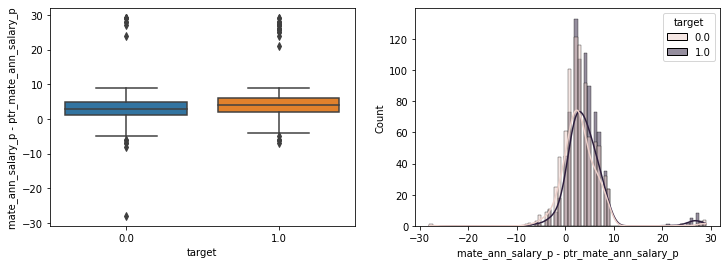

In [13]:
# 연봉 차이
data['mate_ann_salary_p']= data['mate_ann_salary'].apply(salary)
data['ptr_mate_ann_salary_p']= data['ptr_mate_ann_salary'].apply(salary)

data['mate_ann_salary_p - ptr_mate_ann_salary_p']=  data['mate_ann_salary_p'] - data['ptr_mate_ann_salary_p']

fig, axs = plt.subplots(figsize = (12,4), nrows=1, ncols=2)

sns.boxplot(data=data, y= 'mate_ann_salary_p - ptr_mate_ann_salary_p', x = 'target', ax = axs[0])
sns.histplot(data=data, x= 'mate_ann_salary_p - ptr_mate_ann_salary_p', hue = 'target', kde = True, ax = axs[1])

In [14]:
def property(x) :

  if   x == 'b' : return 2
  elif x == 'c' : return 4
  elif x == 'd' : return 8
  elif x == 'e' : return 10 
  elif x == 'f' : return 30
  elif x == 'g' : return 50
  elif x == 'h' : return 100
  elif x == 'm' : return 200
  else : return 300

<AxesSubplot:xlabel='possess_property_p - ptr_possess_property_p', ylabel='Count'>

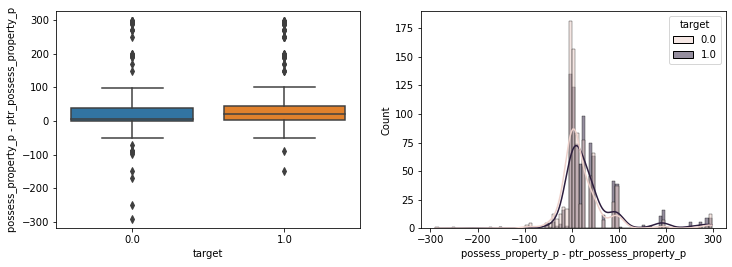

In [15]:
data['possess_property_p']    = data['possess_property'].apply(property)
data['ptr_possess_property_p']= data['ptr_possess_property'].apply(property)

data['possess_property_p - ptr_possess_property_p'] = data['possess_property_p'] - data['ptr_possess_property_p']

fig, axs = plt.subplots(figsize = (12,4), nrows=1, ncols=2)

sns.boxplot(data=data, y= 'possess_property_p - ptr_possess_property_p', x = 'target', ax = axs[0])
sns.histplot(data=data, x= 'possess_property_p - ptr_possess_property_p', hue = 'target', kde = True, ax = axs[1])


<AxesSubplot:xlabel='mate_height - ptr_mate_height', ylabel='Count'>

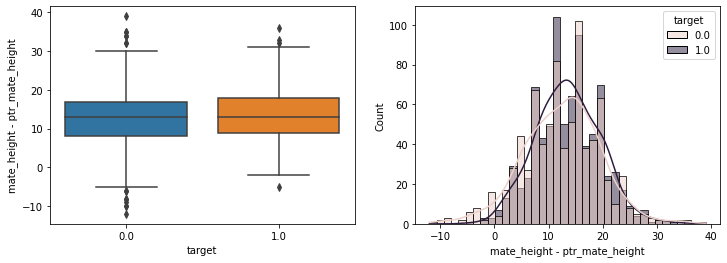

In [16]:
# 키 차이 계산
data['mate_height - ptr_mate_height'] = data['mate_height'] - data['ptr_mate_height']

fig, axs = plt.subplots(figsize = (12,4), nrows=1, ncols=2)

sns.boxplot(data=data, y= 'mate_height - ptr_mate_height', x = 'target', ax = axs[0])
sns.histplot(data=data, x= 'mate_height - ptr_mate_height', hue = 'target', kde = True, ax = axs[1])

In [17]:
def career(x) :

  if     x <= 1 : return 7                           # 초중졸이하 - 7년
  elif   x == 2 : return 12                          # 고졸       - 12년
  elif   x == 3 : return 16                          # 대학 4년   - 16년
  elif   x == 4 : return 18                          # 대학원     - 18년
  elif   x == 5  : return 19                         # 박사과정   - 19년
  elif   (x == 6) | (x == 7) | (x == 8) : return 14  # 대학2년, 대학중퇴, 대학재학 - 14년
  elif   (x == 9) | (x == 10) : return 17            # 대학원재학, 중퇴 - 17년
  elif   x == 11 : return 21                         # 박사 - 21년
  elif   x == 12 : return 15                         # 대학3년 - 15년

In [18]:
data['mate_career'] = data['mate_career'].astype('int64')
data['ptr_mate_career'] = data['ptr_mate_career'].astype('int64')

<AxesSubplot:xlabel='mate_career_p - ptr_mate_career_p', ylabel='Count'>

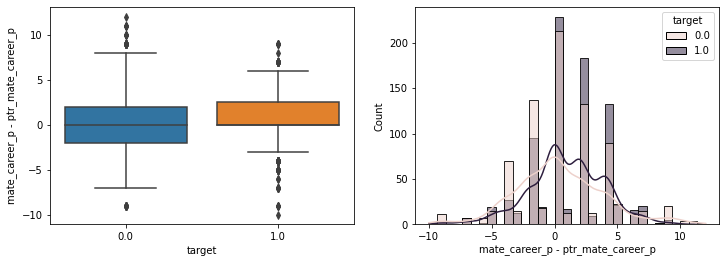

In [19]:
data['mate_career_p'] = data['mate_career'].apply(career)
data['ptr_mate_career_p'] = data['ptr_mate_career'].apply(career)

data['mate_career_p - ptr_mate_career_p']= data['mate_career_p'] - data['ptr_mate_career_p']

fig, axs = plt.subplots(figsize = (12,4), nrows=1, ncols=2)

sns.boxplot(data=data, y= 'mate_career_p - ptr_mate_career_p', x = 'target', ax = axs[0])
sns.histplot(data=data, x= 'mate_career_p - ptr_mate_career_p', hue = 'target', kde = True, ax = axs[1])

# 4. 모델링

In [20]:
# 학습 데이터 생성
X = data[['mate_slct_r','mate_slct_w', 'ptr_mate_slct_r', 'ptr_mate_slct_w', 'mem_birth_year - ptr_mem_birth_year', 'mate_ann_salary_p - ptr_mate_ann_salary_p', 'possess_property_p - ptr_possess_property_p', 
          'mate_career_p - ptr_mate_career_p', 'mate_height - ptr_mate_height', 'mem_loc_p_a', 'mem_loc_p_b', 'mem_loc_p_c', 'mem_loc_p_d', 'mem_loc_p_l', 'mem_loc_p_m', 'mem_loc_p_n', 'mem_loc_p_o', 'mem_loc_p_p', 'mem_loc_p_q', 'ptr_mem_loc_p_a', 'ptr_mem_loc_p_b', 'ptr_mem_loc_p_c', 'ptr_mem_loc_p_d', 'ptr_mem_loc_p_l', 'ptr_mem_loc_p_m', 'ptr_mem_loc_p_n', 'ptr_mem_loc_p_o', 'ptr_mem_loc_p_p', 'ptr_mem_loc_p_q']] 
Y = data['target']

XX = X.iloc[:1638]

YY = Y.iloc[:1638]

test = X.iloc[-20:]

In [21]:
# 데이터 분할 
X_train, X_test, y_train, y_test = train_test_split(XX, YY)

In [22]:
# 모델 학습
model = LogisticRegression()

model.fit(X_train, y_train)

LogisticRegression()

In [23]:
model.classes_

array([0., 1.])

In [24]:
# 성혼율 예측 
model.predict_proba(test)[:,1]

array([0.70038255, 0.40214443, 0.88549013, 0.92565354, 0.93962569,
       0.98242799, 0.81103143, 0.63142729, 0.86232689, 0.61643846,
       0.86660518, 0.83817672, 0.94669457, 0.68073049, 0.90346164,
       0.94938912, 0.97676963, 0.57072035, 0.94703316, 0.69125248])

In [25]:
top20 = top20[['mem_no','ptr_mem_no']]
top20['Predicted Marriage Rate'] = model.predict_proba(test)[:,1]

In [26]:
top20.sort_values('Predicted Marriage Rate', ascending=False).head(3)

,mem_no,ptr_mem_no,Predicted Marriage Rate
5,31,641838,0.982428
16,31,69020,0.976770
15,31,653001,0.949389
